In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
from tqdm import tqdm
from vasili_helpers import *
import pandas as pd
from typing import Tuple
import h5py
import argparse


def get_dataset_named(dataset_name):
    print(f"Dataset = {dataset_name}")
    D, dimension = get_dataset_ann_benchmarks(dataset_name)
    xq, xb, gt, xt, (nq, d) = D['test'], D['train'], D['neighbors'], D['train'], D['test'].shape
    xq, xb, gt, xt, = np.array(xq), np.array(xb), np.array(gt), np.array(xt),
    return  xq, xb, gt, xt, nq, d

def get_dataset_fn_ann_benchmarks(dataset_name: str) -> str:
    # from ann-benchmarks
    """
    Returns the full file path for a given dataset name in the data directory.
    
    Args:
        dataset_name (str): The name of the dataset.
    
    Returns:
        str: The full file path of the dataset.
    """
    if not os.path.exists(f"{BASE_DATA_FOLDER}/data/datasets"):
        os.mkdir(f"{BASE_DATA_FOLDER}/data/datasets")
    return os.path.join(f"{BASE_DATA_FOLDER}/data/datasets", f"{dataset_name}.hdf5")

def download_ann_benchmarks(source_url: str, destination_path: str) -> None:
    """
    Downloads a file from the provided source URL to the specified destination path
    only if the file doesn't already exist at the destination.
    
    Args:
        source_url (str): The URL of the file to download.
        destination_path (str): The local path where the file should be saved.
    """
    if os.path.exists(destination_path):
        print(f"File already exists at {destination_path}. Skipping download.")
        return

    print(f"Downloading {source_url} -> {destination_path}...")
    try:
        with requests.get(source_url, stream=True) as response:
            response.raise_for_status()  # Raise an HTTPError for bad responses (4xx, 5xx)
            total_size = int(response.headers.get('content-length', 0))
            with open(destination_path, 'wb') as file, tqdm(
                desc=destination_path,
                total=total_size,
                unit='B',
                unit_scale=True,
                unit_divisor=1024,
            ) as bar:
                for chunk in response.iter_content(chunk_size=8192):  # 8 KB chunks
                    file.write(chunk)
                    bar.update(len(chunk))
    except Exception as e:
        print(f"Error downloading {source_url}: {e}")


def get_dataset_ann_benchmarks(dataset_name: str) -> Tuple[h5py.File, int]:
    # from ann_benchmarks
    """
    Fetches a dataset by downloading it from a known URL or creating it locally
    if it's not already present. The dataset file is then opened for reading, 
    and the file handle and the dimension of the dataset are returned.
    
    Args:
        dataset_name (str): The name of the dataset.
    
    Returns:
        Tuple[h5py.File, int]: A tuple containing the opened HDF5 file object and
            the dimension of the dataset.
    """
    hdf5_filename = get_dataset_fn_ann_benchmarks(dataset_name)
    try:
        dataset_url = f"https://ann-benchmarks.com/{dataset_name}.hdf5"
        download_ann_benchmarks(dataset_url, hdf5_filename)
    except:
        print(f"Cannot download {dataset_url}")

    hdf5_file = h5py.File(hdf5_filename, "r")

    # here for backward compatibility, to ensure old datasets can still be used with newer versions
    # cast to integer because the json parser (later on) cannot interpret numpy integers
    dimension = int(hdf5_file.attrs["dimension"]) if "dimension" in hdf5_file.attrs else len(hdf5_file["train"][0])
    return hdf5_file, dimension

def plot_individual(dataset_name, counts, nprobe, nqueries, save_plot=False, yscale='linear'):
    """
    Plot the cluster frequency for an individual dataset.

    Args:
        dataset_name (str): Name of the dataset.
        counts (array): Array of cluster frequencies.
        nprobe (int): Number of probes used.
        nqueries (int): Number of queries.
        save_plot (bool): Whether to save the plot as an image.
        yscale (str): Scale of y-axis ('linear' or 'log').
    """
    sorted_counts = np.sort(counts)[::-1]  # Sort counts in descending order

    plt.figure()
    plt.plot(sorted_counts, marker='o', linestyle='-', color='navy', linewidth=1, alpha=0.8,
             markerfacecolor='white', markeredgecolor='navy', markeredgewidth=0.5)
    plt.xlabel('Cluster_id (sorted by freq)')
    plt.ylabel('Frequency')
    plt.yscale(yscale)  # Set y-axis scale
    plt.title(f'Cluster Frequency - {dataset_name} - {nprobe=} - {nqueries=}')
    plt.grid(True)
    if save_plot:
        plt.savefig(f"{dataset_name}_skew_{nprobe=}_{yscale}.png")
    plt.show(block=False)


def plot_combined(datasets_counts, nprobe, nqueries_dict, save_plot=False, normalize=False, yscale='linear'):
    """
    Plot the cluster frequency for all datasets combined with unique colors, using percentage-based x-axis.

    Args:
        datasets_counts (dict): Dictionary of dataset names and their corresponding counts arrays.
        nprobe (int): Number of probes used.
        nqueries_dict (dict): Dictionary mapping dataset names to the number of queries for normalization.
        save_plot (bool): Whether to save the plot as an image.
        normalize (bool): Whether to normalize counts by number of queries.
        yscale (str): Scale of y-axis ('linear' or 'log').
    """
    plt.figure()

    for i, (dataset_name, counts) in enumerate(datasets_counts.items()):
        counts = np.array(counts)  # Ensure counts is NumPy array
        
        # Compute normalized values if required
        if normalize:
            nqueries = nqueries_dict[dataset_name]
            normalized_counts = (counts / nqueries) * 100  # Convert to percentage
        else:
            normalized_counts = counts  # Keep original values
        
        sorted_counts = np.sort(normalized_counts)[::-1]  # Sort in descending order
        
        # Compute x-axis as percentage
        total_partitions = counts.size  # Number of partitions
        x_percent = (np.arange(1, total_partitions + 1) / total_partitions) * 100  # Convert to percentage
        
        # Plot with percentage-based x-axis
        plt.plot(x_percent, sorted_counts, marker='o', linestyle='-', linewidth=1, alpha=0.8,
                 label=dataset_name, markersize=4)

    plt.xlabel('% of Partitions (sorted by access frequency)')  # Updated x-label
    if normalize:
        plt.ylabel('% of Queries')  # Updated y-label
        plt.title(f'Partition Access Skew (Normalized-Percentage) - Multiple Datasets')
    else:
        plt.ylabel('Access Frequency')
        plt.title(f'Combined Cluster Frequency - {nprobe=} - Multiple Datasets')
    
    plt.yscale(yscale)  # Set y-axis scale
    plt.legend()
    plt.grid(True)

    if save_plot:
        filename = f"combined_plot_{'normalized' if normalize else ''}_{nprobe}_{yscale}.png"
        plt.savefig(filename)

    plt.show(block=False)

# def plot_combined(datasets_counts, nprobe, nqueries_dict, save_plot=False, normalize=False, yscale='linear'):
#     """
#     Plot the cluster frequency for all datasets combined with unique colors.

#     Args:
#         datasets_counts (dict): Dictionary of dataset names and their corresponding counts arrays.
#         nprobe (int): Number of probes used.
#         nqueries_dict (dict): Dictionary mapping dataset names to the number of queries for normalization.
#         save_plot (bool): Whether to save the plot as an image.
#         normalize (bool): Whether to normalize counts by number of queries.
#         yscale (str): Scale of y-axis ('linear' or 'log').
#     """
#     plt.figure()

#     for i, (dataset_name, counts) in enumerate(datasets_counts.items()):
#         if normalize:
#             nqueries = nqueries_dict[dataset_name]
#             normalized_counts = ( counts / nqueries ) * 100
#             sorted_counts = np.sort(normalized_counts)[::-1]
#         else:
#             sorted_counts = np.sort(counts)[::-1]

#         plt.plot(sorted_counts, marker='o', linestyle='-', linewidth=1, alpha=0.8,
#                  label=dataset_name, markersize=4)

#     plt.xlabel('Cluster_id (sorted by freq)')
#     if normalize:
#         # plt.ylabel('Frequency (normalized by number of queries)')
#         plt.ylabel('% of queries')
#         plt.title(f'Partition Access Skew (Normalized-Percentage) - Multiple Datasets')
#     else:
#         plt.ylabel('Frequency')
#         plt.title(f'Combined Cluster Frequency - {nprobe=} - Multiple Datasets')
#     plt.yscale(yscale)  # Set y-axis scale
#     plt.legend()
#     plt.grid(True)
#     if save_plot:
#         if normalize:
#             plt.savefig(f"combined_plot_normalized_{nprobe=}_{yscale}.png")
#         else:
#             plt.savefig(f"combined_plot_{nprobe=}_{yscale}.png")
#     plt.show(block=False)


def get_skew_across_queries(index, queries, nprobe=10, dataset_name='unknown-dataset',
                          save_individual_plot=False, datasets_counts=None, yscale='linear'):
    """
    Perform quantization and return centroid IDs along with counts.

    Args:
        index: The FAISS index.
        queries (array): Query vectors.
        nprobe (int): Number of probes.
        dataset_name (str): Name of the dataset.
        save_individual_plot (bool): Whether to save individual plots.
        datasets_counts (dict): Optional dictionary to store counts for combined plots.
        yscale (str): Scale of y-axis ('linear' or 'log').
    """
    _, cids = index.quantizer.search(queries, nprobe)
    n_centroids = index.nlist
    counts = np.zeros(n_centroids, dtype=int)

    visited_cids, cid_counts = np.unique(cids.flatten(), return_counts=True)
    counts[visited_cids] = cid_counts

    if datasets_counts is not None:
        datasets_counts[dataset_name] = counts

    plot_individual(dataset_name, counts, nprobe, len(queries), save_individual_plot, yscale)
    return visited_cids, counts

def plot_skew_for_dataset(xb, xq, nlist, d, metric, dataset_name, search_nprobe=1, combined_counts=None):
    
    # https://faiss.ai/cpp_api/file/MetricType_8h.html#_CPPv4N5faiss10MetricTypeE
    if metric == 'angular':
        xb = xb / np.linalg.norm(xb, axis=1, keepdims=True)
        xq = xq / np.linalg.norm(xq, axis=1, keepdims=True)
        quantizer = faiss.IndexFlatIP(d)
        index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)
    elif metric == 'euclidean':
        quantizer = faiss.IndexFlatL2(d)
        index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_L2)
    elif metric == "hamming":
        #TODO: hamming & jaccard need fixing 
        quantizer = faiss.IndexBinaryFlat(d)  # Use IndexBinaryFlat as the base (brute-force for binary data)
        index = faiss.IndexBinaryIVF(quantizer, d, nlist)
    elif metric == "jaccard":
        quantizer = faiss.IndexFlat(d, metric=faiss.METRIC_Jaccard)
        index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_Jaccard)
    elif metric == "dot":
        quantizer = faiss.IndexFlatIP(d)
        index = faiss.IndexIVFFlat(quantizer, d, nlist, faiss.METRIC_INNER_PRODUCT)
        

    # trained_index.cp.seed = int(time.time())
    index.cp.niter= 10
    index.cp.nredo = 1
    index.verbose=True
    index.cp.seed = 42 # consitency

    index.train(xb)
    index.add(xb)

    _, counts = get_skew_across_queries(
        index=index,
        queries=xq,
        nprobe=search_nprobe,
        dataset_name=dataset_name,
        save_individual_plot=True,
        datasets_counts=combined_counts,
    )

    return

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_combined_heatmap(datasets_counts, nprobe, nqueries_dict, save_plot=False, normalize=False, log_scale=False):
    """
    Plot the cluster frequency for all datasets as a heatmap with optional log scale.

    Args:
        datasets_counts (dict): Dictionary of dataset names and their corresponding counts arrays.
        nprobe (int): Number of probes used.
        nqueries_dict (dict): Dictionary mapping dataset names to the number of queries for normalization.
        save_plot (bool): Whether to save the plot as an image.
        normalize (bool): Whether to normalize counts by number of queries.
        log_scale (bool): Whether to apply log scale to the heatmap values.
    """
    # Convert datasets_counts to a sorted frequency matrix
    heatmap_data = {}

    for dataset_name, counts in datasets_counts.items():
        # if normalize:
        #     nqueries = nqueries_dict[dataset_name]
        #     normalized_counts = counts / nqueries
        #     sorted_counts = np.sort(normalized_counts)[::-1]
        # if normalize:

        #     total_counts = counts.sum()  # Total queries for this dataset
            
        #     # Normalize each count by total accesses (fraction of workload per cluster)
        #     normalized_counts = counts / total_counts
            # sorted_counts = np.sort(normalized_counts)[::-1]  # Sort descending
        if normalize:
            # min-max scaling
            # Min-Max Scaling ((counts - min) / (max - min))	Preserving distribution shape across datasets	Values range 0 to 1, with relative scaling

            # 1 means most access 0 is least accessed
            min_count = counts.min()
            max_count = counts.max()
            
            # Avoid divide by zero if all counts are the same
            if max_count != min_count:
                normalized_counts = (counts - min_count) / (max_count - min_count)
            else:
                normalized_counts = np.zeros_like(counts)  # All values would be 0 if no variance

            sorted_counts = np.sort(normalized_counts)[::-1]

        else:
            sorted_counts = np.sort(counts)[::-1]

        heatmap_data[dataset_name] = sorted_counts

    # Convert to DataFrame for heatmap
    df_heatmap = np.array(list(heatmap_data.values()))

    # Apply log transformation if needed
    if log_scale:
        df_heatmap = np.log1p(df_heatmap)  # log(1 + x) to handle zeros safely

    # Determine vmin and vmax for better contrast
    # vmin, vmax = np.percentile(df_heatmap, 1), np.percentile(df_heatmap, 99)

    # Plot heatmap
    cmap_choice = "cividis"
    plt.figure(figsize=(8, 8))
    # sns.heatmap(df_heatmap,  
    #             # cmap="viridis",  
    #             cmap="cividis",  
    #             cbar=True,  
    #             linewidths=0,  
    #             xticklabels=100,  
    #             yticklabels=list(heatmap_data.keys()),  
    #             # vmin=vmin,  
    #             # vmax=vmax
    #             )

    ax = sns.heatmap(df_heatmap,  
                cmap=cmap_choice,  
                cbar=True,  
                linewidths=0,  # Thin lines
                linecolor="white",  # White grid lines for clarity
                xticklabels=100,  
                yticklabels=list(heatmap_data.keys()),  
                # vmin=vmin,  
                # vmax=vmax
                )


    FONT_SIZE = 16


    # ✅ Retrieve the colorbar from the heatmap and adjust tick size
    cbar = ax.collections[0].colorbar  # Get colorbar from heatmap
    cbar.ax.tick_params(labelsize=FONT_SIZE)  # Adjust fontsiz

    plt.xticks(rotation=45, ha="right", fontsize=FONT_SIZE)
    plt.yticks(rotation=45, fontsize=FONT_SIZE)
    
    # plt.xlabel("Cluster ID (sorted by frequency)", fontsize=14, labelpad=10)
    # plt.xlabel("Cluster Rank (Most Accessed to Least Accessed)", fontsize=14, labelpad=10)
    plt.xlabel("Partition Rank (Most Accessed to Least Accessed)", fontsize=FONT_SIZE, labelpad=12)
    plt.ylabel("Datasets", fontsize=FONT_SIZE, labelpad=12)

    # plt.ylabel("Datasets", fontsize=14, labelpad=10)

    # Adjust title based on log scale
    # title = "Log-Scaled Heatmap of Cluster Frequency Skew" if log_scale else "Heatmap of Cluster Frequency Skew"
    title = "Log-Scaled Partition Access Skew Across Datasets" if log_scale else "Partition Access Skew Across Datasets"
    plt.title(f"{title}", fontsize=FONT_SIZE, fontweight="bold", pad=15)

    plt.tight_layout()

    # Save plot if required
    if save_plot:
        filename = f"FINAL_combined_heatmap_{'log_' if log_scale else ''}{'normalized_' if normalize else ''}nprobe_{nprobe}.png"
        plt.savefig(filename, dpi=600)


    plt.show(block=False)


In [3]:
# # Define the list of datasets to keep
# selected_datasets = ['deep-image', 'fashion-mnist', 'gist-960', 'glove-25', 
#                      'glove-50', 'glove-100', 'glove-200', 'mnist-784', 
#                      'sift-128', 'lastfm-64', 'text2image', 'sift1m', 
#                      'coco-i2i', 'coco-t2i']

# # ✅ Create a copy of only the selected datasets
# cop = combined_counts[selected_datasets].copy()

# # Display the new copied dataframe
# # import ace_tools as tools
# # tools.display_dataframe_to_user(name="Filtered Combined Counts", dataframe=cop)


In [4]:
# plot_combined_heatmap(combined_counts, search_nprobe, nqueries_dict, save_plot=True, normalize=True)

  0%|          | 0/4 [00:00<?, ?it/s]

Loading Dataset = deep-image-96-angular
File already exists at /pub/scratch/vmageirakos/vdb-project-data/data/datasets/deep-image-96-angular.hdf5. Skipping download.
Training level-1 quantizer
Training level-1 quantizer on 9990000 vectors in 96D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 9990000 / 9990000 vectors


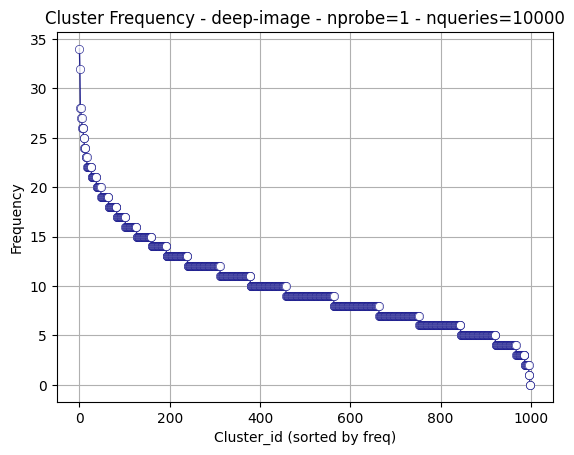

 25%|██▌       | 1/4 [05:28<16:24, 328.14s/it]

Loading Dataset = glove-50-angular
File already exists at /pub/scratch/vmageirakos/vdb-project-data/data/datasets/glove-50-angular.hdf5. Skipping download.
normalizing for glove-50-angular because metric = angular
Training level-1 quantizer
Training level-1 quantizer on 1183514 vectors in 50D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1183514 / 1183514 vectors


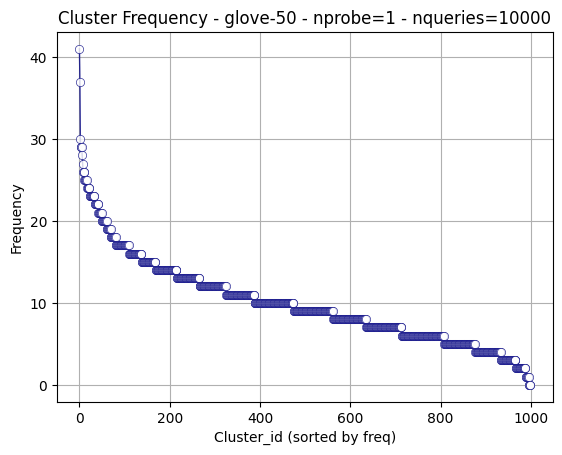

 50%|█████     | 2/4 [05:42<04:46, 143.43s/it]

Loading Dataset = lastfm-64-dot
File already exists at /pub/scratch/vmageirakos/vdb-project-data/data/datasets/lastfm-64-dot.hdf5. Skipping download.
Training level-1 quantizer
Training level-1 quantizer on 292385 vectors in 65D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 292385 / 292385 vectors


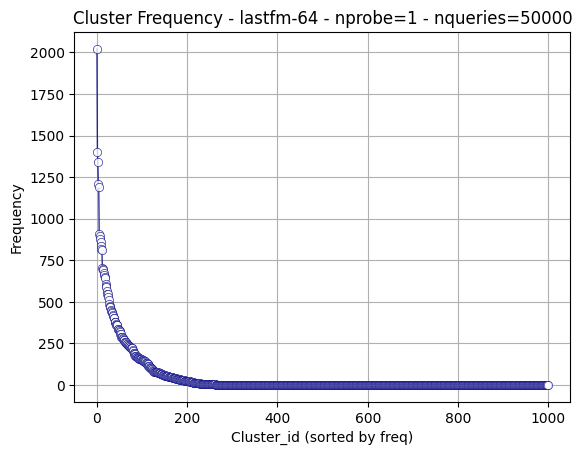

 75%|███████▌  | 3/4 [05:53<01:22, 82.84s/it] 

Loading Dataset = SIFT1M
Training level-1 quantizer
Training level-1 quantizer on 1000000 vectors in 128D
Training IVF residual
IndexIVF: no residual training
IndexIVFFlat::add_core: added 1000000 / 1000000 vectors


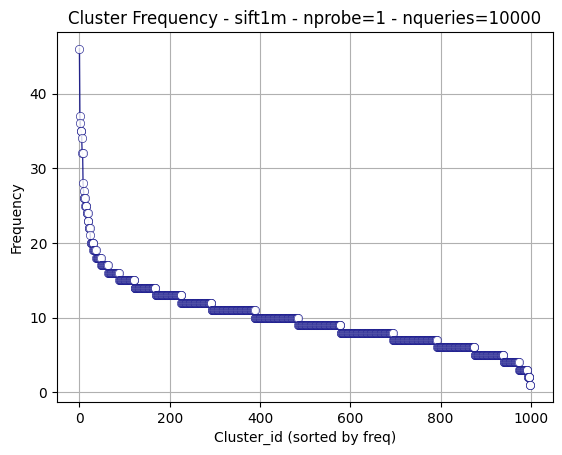

100%|██████████| 4/4 [07:01<00:00, 105.33s/it]


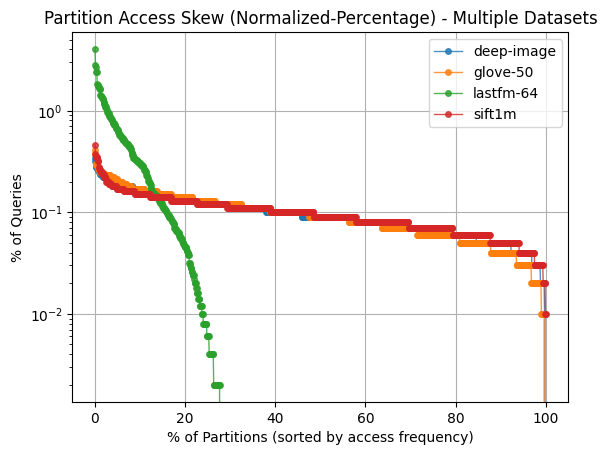

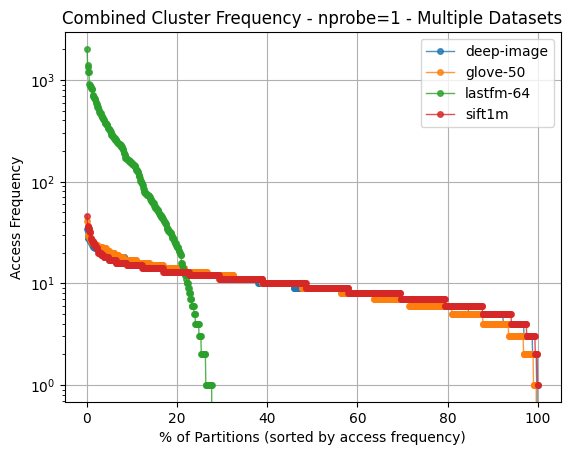

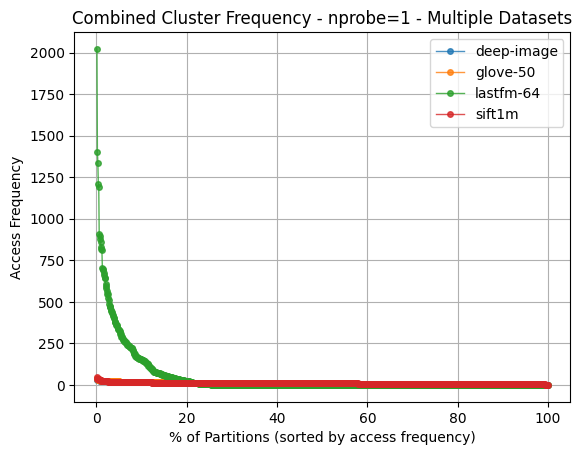

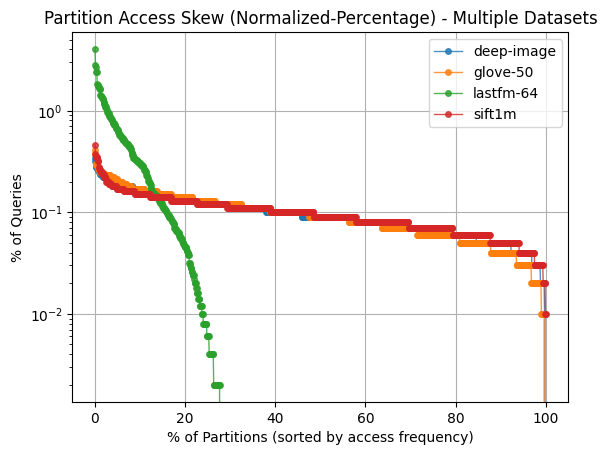

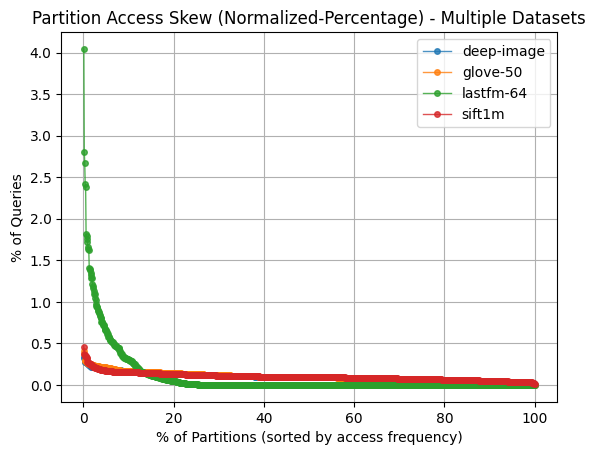

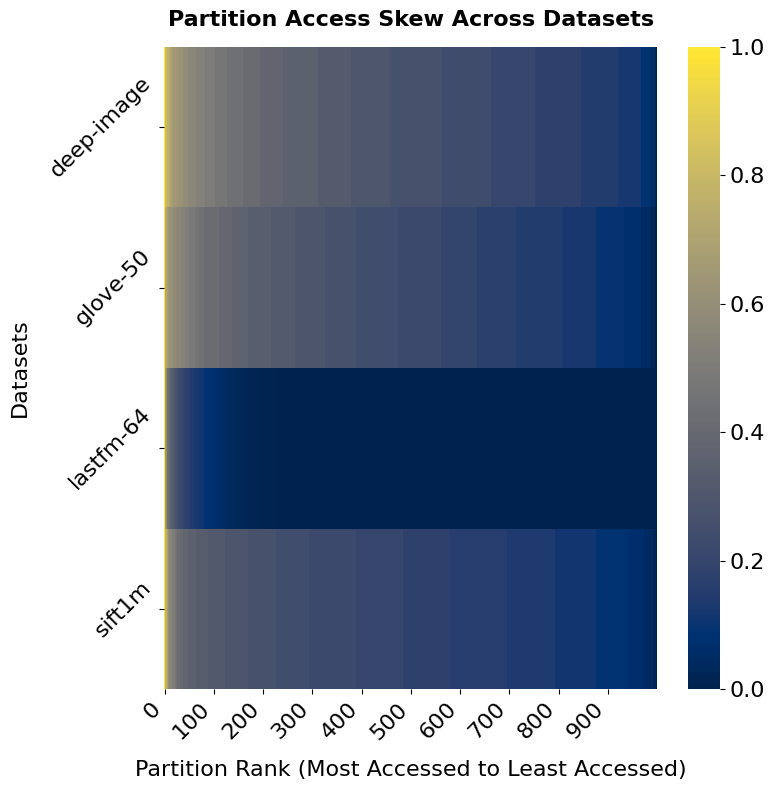

nqueries_dict={'deep-image': 10000, 'glove-50': 10000, 'lastfm-64': 50000, 'sift1m': 10000}
sizes_dict={'deep-image': 9990000, 'glove-50': 1183514, 'lastfm-64': 292385, 'sift1m': 1000000}


In [ ]:
BASE_DATA_FOLDER='/pub/scratch/vmageirakos/vdb-project-data'
# BASE_DATA_FOLDER='/Users/mageirakos/Documents/projects/crack-vdb'

combined_counts = {}
sizes_dict = {}
nqueries_dict = {}  # Dictionary to store nq for each dataset
nlist = 1000
search_nprobe = 1
yscale = "log" # linear


ANN_DATASETS = [
        "deep-image-96-angular",
        # "glove-25-angular",
        "glove-50-angular",
        # "glove-100-angular",
        "lastfm-64-dot",
        "SIFT1M",
        # "SIFT10M",
]
def clean_dataset_name(dataset_name):
    """
    Remove dimensionality and distance information from dataset names,
    keeping at least two meaningful parts in lowercase.
    """
    parts = dataset_name.lower().split("-")
    return "-".join(parts[:2]) if len(parts) > 1 else parts[0]  # Keep two key parts

# Apply renaming to all datasets
for dataset_name in tqdm(ANN_DATASETS):
    metric = dataset_name.split('-')[-1]
    xb, xq, gt, metric = load_dataset(dataset_name)
    nq,d = xq.shape
    dataset_name = clean_dataset_name(dataset_name)

    nqueries_dict[dataset_name] = nq
    sizes_dict[dataset_name] = xb.shape[0]
    plot_skew_for_dataset(xb, xq, nlist, d, metric, dataset_name, search_nprobe, combined_counts)

# Generate combined plot
# plot_combined(combined_counts, search_nprobe, nqueries_dict, save_plot=True, normalize=True)
# plot_combined(combined_counts, search_nprobe, nqueries_dict, save_plot=True, normalize=False)
plot_combined(combined_counts, search_nprobe, nqueries_dict, save_plot=True, normalize=True, yscale=yscale)
plot_combined(combined_counts, search_nprobe, nqueries_dict, save_plot=True, normalize=False, yscale=yscale)
plot_combined(combined_counts, search_nprobe, nqueries_dict, save_plot=True, normalize=False, yscale="linear")
plot_combined(combined_counts, search_nprobe, nqueries_dict, save_plot=True, normalize=True, yscale=yscale)
plot_combined(combined_counts, search_nprobe, nqueries_dict, save_plot=True, normalize=True, yscale="linear")
plot_combined_heatmap(combined_counts, search_nprobe, nqueries_dict, save_plot=True, normalize=True)

print(f"{nqueries_dict=}")
print(f"{sizes_dict=}") #TODO: check if they are all same size to be fair, and then see how this scales to larger sizes

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_combined(datasets_counts, nprobe, nqueries_dict, save_plot=False, normalize=False, yscale='linear'):
    """
    Plot the cluster frequency for all datasets combined with unique colors, using percentage-based x-axis.

    Args:
        datasets_counts (dict): Dictionary of dataset names and their corresponding counts arrays.
        nprobe (int): Number of probes used.
        nqueries_dict (dict): Dictionary mapping dataset names to the number of queries for normalization.
        save_plot (bool): Whether to save the plot as an image.
        normalize (bool): Whether to normalize counts by number of queries.
        yscale (str): Scale of y-axis ('linear' or 'log').
    """
    plt.figure(figsize=(6, 4))  # Set figure size for better readability

    for dataset_name, counts in datasets_counts.items():
        counts = np.array(counts)  # Ensure counts is a NumPy array

        # Compute normalized values if required
        if normalize:
            nqueries = nqueries_dict[dataset_name]
            normalized_counts = (counts / nqueries) * 100  # Convert to percentage
        else:
            normalized_counts = counts  # Keep original values

        sorted_counts = np.sort(normalized_counts)[::-1]  # Sort in descending order

        # Compute x-axis as percentage
        total_partitions = counts.size  # Number of partitions
        x_percent = (np.arange(1, total_partitions + 1) / total_partitions) * 100  # Convert to percentage

        # Plot with percentage-based x-axis (REMOVED MARKERS, SMOOTH LINES)
        plt.plot(x_percent, sorted_counts, linestyle='-', linewidth=3, alpha=0.9, label=dataset_name)
        # plt.plot(x_percent, sorted_counts, marker='o', linestyle='', markersize=2, alpha=0.8, label=dataset_name)


    FONT_SIZE = 12
    # Improved labels
    plt.xlabel('% of Partitions (Sorted by Access Frequency)', fontsize=FONT_SIZE, weight='bold')
    plt.xlabel('% of Partitions', fontsize=FONT_SIZE, weight='bold')
    plt.ylabel('% of Queries' if normalize else 'Access Frequency', fontsize=FONT_SIZE, weight='bold')

    # Title with formatting
    # title_text = 'Partition Access Skew (Normalized-Percentage) - Multiple Datasets' if normalize else \
                #  f'Combined Cluster Frequency - {nprobe=} - Multiple Datasets'
    
    
    title_text = 'Partition Access Skew - ID vs OOD'
    plt.title(title_text, fontsize=14, weight='bold')

    plt.xticks(fontsize=FONT_SIZE)
    plt.yticks(fontsize=FONT_SIZE)


    # Set y-axis scale
    plt.yscale(yscale)

    # Improved legend
    plt.legend(fontsize=16, loc='best', frameon=True)

    # Enhanced grid for better readability
    plt.grid(True, linestyle='--', alpha=0.6)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Save the plot if needed
    
    # Save the plot if needed
    if save_plot:
        # Save as high-quality PDF
        pdf_filename = "pdf_access_skew_fig1.pdf"
        plt.savefig(pdf_filename, format="pdf", dpi=600, bbox_inches='tight')

    plt.show(block=False)


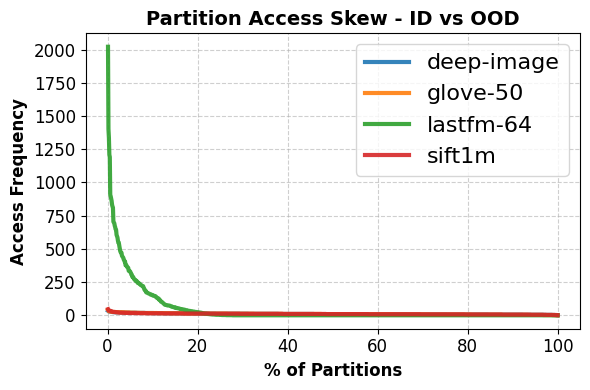

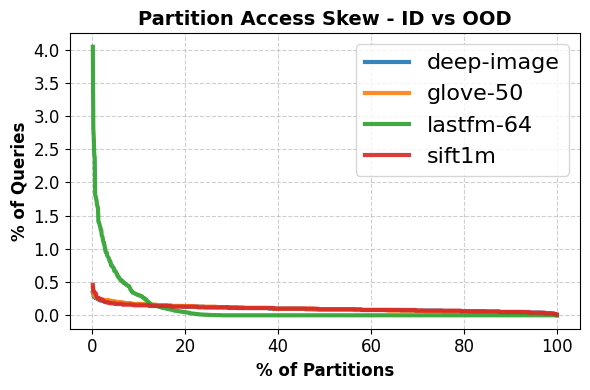

In [7]:
plot_combined(combined_counts, search_nprobe, nqueries_dict, save_plot=True, normalize=False, yscale="linear")
plot_combined(combined_counts, search_nprobe, nqueries_dict, save_plot=True, normalize=True, yscale="linear")

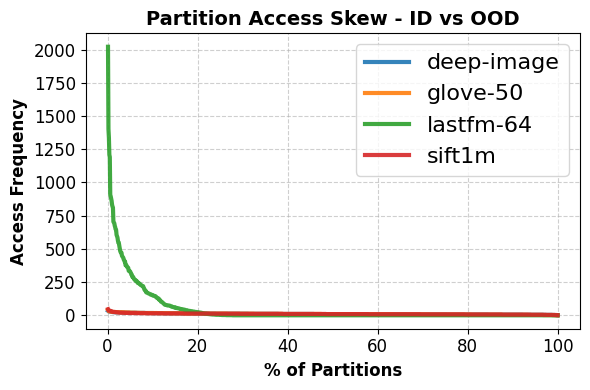

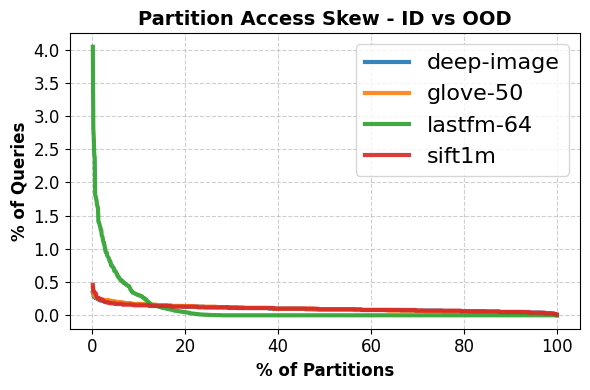

In [8]:
plot_combined(combined_counts, search_nprobe, nqueries_dict, save_plot=True, normalize=False, yscale="linear")
plot_combined(combined_counts, search_nprobe, nqueries_dict, save_plot=True, normalize=True, yscale="linear")


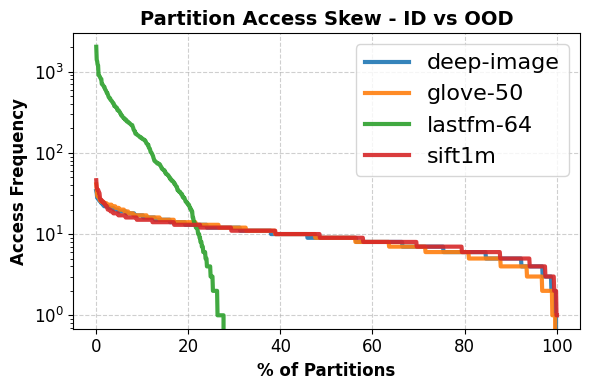

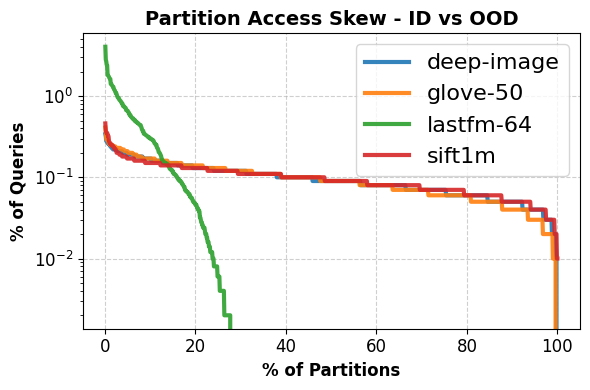

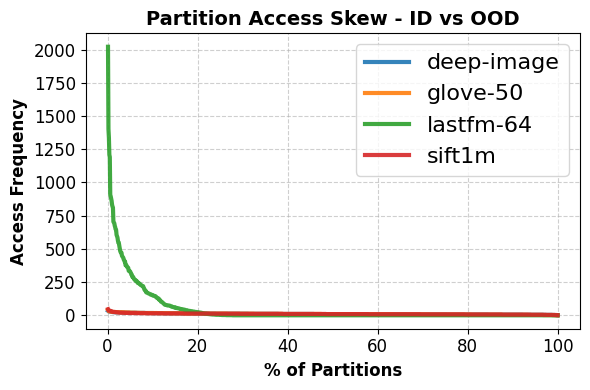

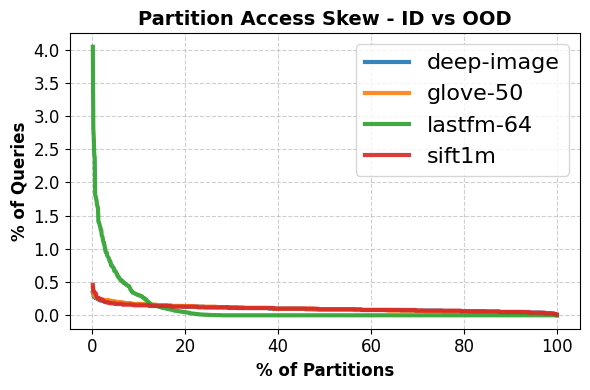

In [9]:
plot_combined(combined_counts, search_nprobe, nqueries_dict, save_plot=True, normalize=False, yscale="log")
plot_combined(combined_counts, search_nprobe, nqueries_dict, save_plot=True, normalize=True, yscale="log")
plot_combined(combined_counts, search_nprobe, nqueries_dict, save_plot=True, normalize=False, yscale="linear")
plot_combined(combined_counts, search_nprobe, nqueries_dict, save_plot=True, normalize=True, yscale="linear")

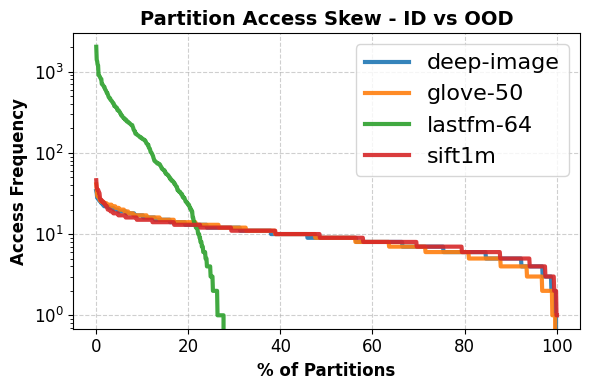

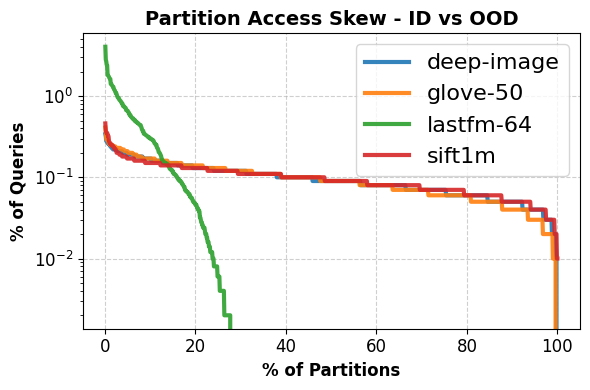

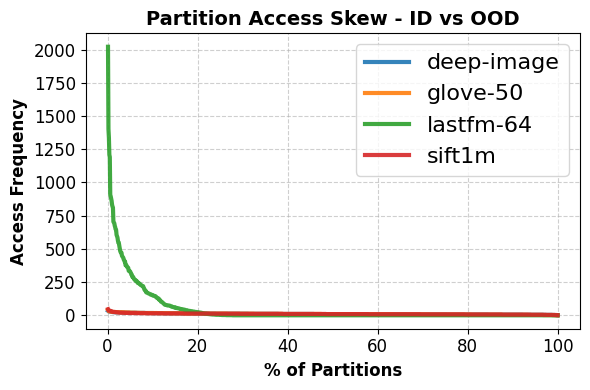

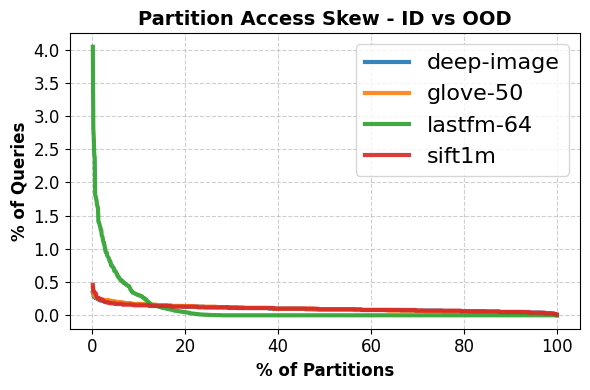

In [10]:
plot_combined(combined_counts, search_nprobe, nqueries_dict, save_plot=True, normalize=False, yscale="log")
plot_combined(combined_counts, search_nprobe, nqueries_dict, save_plot=True, normalize=True, yscale="log")
plot_combined(combined_counts, search_nprobe, nqueries_dict, save_plot=True, normalize=False, yscale="linear")
plot_combined(combined_counts, search_nprobe, nqueries_dict, save_plot=True, normalize=True, yscale="linear")

Try out CDF


In [11]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cdf_combined(datasets_counts, nprobe, nqueries_dict, save_plot=False, normalize=False):
    """
    Plot the Cumulative Distribution Function (CDF) of cluster access frequencies for all datasets.

    Args:
        datasets_counts (dict): Dictionary of dataset names and their corresponding counts arrays.
        nprobe (int): Number of probes used.
        nqueries_dict (dict): Dictionary mapping dataset names to the number of queries for normalization.
        save_plot (bool): Whether to save the plot as an image.
        normalize (bool): Whether to normalize counts by number of queries.
    """
    plt.figure(figsize=(8, 5))  # Set figure size

    for dataset_name, counts in datasets_counts.items():
        counts = np.array(counts)  # Ensure counts is a NumPy array

        # Compute normalized values if required
        if normalize:
            nqueries = nqueries_dict[dataset_name]
            normalized_counts = (counts / nqueries) * 100  # Convert to percentage
        else:
            normalized_counts = counts  # Keep original values

        sorted_counts = np.sort(normalized_counts)[::-1]  # Sort in descending order

        # Compute x-axis as percentage
        total_partitions = counts.size  # Number of partitions
        x_percent = (np.arange(1, total_partitions + 1) / total_partitions) * 100  # Convert to percentage

        # Compute CDF
        cdf = np.cumsum(sorted_counts) / np.sum(sorted_counts) * 100  # Normalize to percentage

        # Find the x position where CDF reaches 100%
        max_cdf_index = np.argmax(cdf >= 100)  # First index where CDF reaches 100%
        max_cdf_x = x_percent[max_cdf_index]  # Corresponding x-axis value

        # Plot the CDF
        plt.plot(x_percent, cdf, linestyle='-', linewidth=2, alpha=0.9, label=dataset_name)

        # Add marker at 100% point
        plt.scatter(max_cdf_x, 100, color='black', marker="x", s=50, zorder=3)  # Marker at (x, 100%)

    # Add uniform access diagonal (y = x)
    plt.plot([0, 100], [0, 100], linestyle='--', color='black', linewidth=1.5, label="Uniform Access")

    # Improved labels
    plt.xlabel('% of Partitions', fontsize=12, weight='bold')
    plt.ylabel('% of Queries', fontsize=12, weight='bold')

    # Title with formatting
    title_text = 'Cumulative Distribution Function (CDF) - Partition Access'
    plt.title(title_text, fontsize=14, weight='bold')

    # Improved legend
    plt.legend(fontsize=10, loc='best', frameon=True)

    # Enhanced grid for better readability
    plt.grid(True, linestyle='--', alpha=0.6)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Save the plot if needed
    if save_plot:
        # Save as high-quality PDF
        pdf_filename = "cdf_partition_query_fig1.pdf"
        plt.savefig(pdf_filename, format="pdf", dpi=600, bbox_inches='tight')

    plt.show(block=False)


In [26]:
def plot_cdf_flipped(datasets_counts, nprobe, nqueries_dict, save_plot=False, normalize=False):
    """
    Plot the flipped (inverse) CDF of cluster access frequencies.
    - X-axis: Cumulative % of Queries
    - Y-axis: % of Partitions (Sorted by Access Frequency)

    Args:
        datasets_counts (dict): Dictionary of dataset names and their corresponding counts arrays.
        nprobe (int): Number of probes used.
        nqueries_dict (dict): Dictionary mapping dataset names to the number of queries for normalization.
        save_plot (bool): Whether to save the plot as an image.
        normalize (bool): Whether to normalize counts by number of queries.
    """
    plt.figure(figsize=(8, 5))  # Set figure size
    FONT_SIZE = 16
    for dataset_name, counts in datasets_counts.items():
        counts = np.array(counts)  # Ensure counts is a NumPy array

        # Compute normalized values if required
        if normalize:
            nqueries = nqueries_dict[dataset_name]
            normalized_counts = (counts / nqueries) * 100  # Convert to percentage
        else:
            normalized_counts = counts  # Keep original values

        sorted_counts = np.sort(normalized_counts)[::-1]  # Sort in descending order

        # Compute y-axis as percentage (this is now the Y-axis!)
        total_partitions = counts.size
        y_percent = (np.arange(1, total_partitions + 1) / total_partitions) * 100

        # Compute CDF (this is now the X-axis!)
        cdf = np.cumsum(sorted_counts) / np.sum(sorted_counts) * 100  # Normalize to percentage

        # Find the y position where CDF reaches 100%
        max_cdf_index = np.argmax(cdf >= 100)  # First index where CDF reaches 100%
        max_cdf_y = y_percent[max_cdf_index]  # Corresponding y-axis value

        # Plot the flipped CDF
        plt.plot(cdf, y_percent, linestyle='-', linewidth=2, alpha=0.9, label=dataset_name)

        # Add marker at 100% point
        plt.scatter(100, max_cdf_y, color='black', marker="x", s=50, zorder=3)  # Marker at (100%, y)

    # Add uniform access diagonal (x = y)
    plt.plot([0, 100], [0, 100], linestyle='--', color='black', linewidth=1.5, label="Uniform Access")

    # Improved labels (Swapped)
    plt.xlabel('% of Total Queries', fontsize=FONT_SIZE)
    plt.ylabel('% of Partitions Accessed', fontsize=FONT_SIZE)

    # Title with formatting
    # title_text = 'Flipped CDF - Partition Access'
    title_text = "CDF of Partition Accesses"
    plt.title(title_text, fontsize=FONT_SIZE)

    # Improved legend
    plt.legend(fontsize=16, loc='best', frameon=True)

    # Enhanced grid for better readability
    plt.grid(True, linestyle='--', alpha=0.6)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Save the plot if needed
    if save_plot:
        # Save as high-quality PDF
        pdf_filename = "intro_fig_1_cdf_query_partition_2.pdf"
        plt.savefig(pdf_filename, format="pdf", dpi=600, bbox_inches='tight')


    plt.show(block=False)


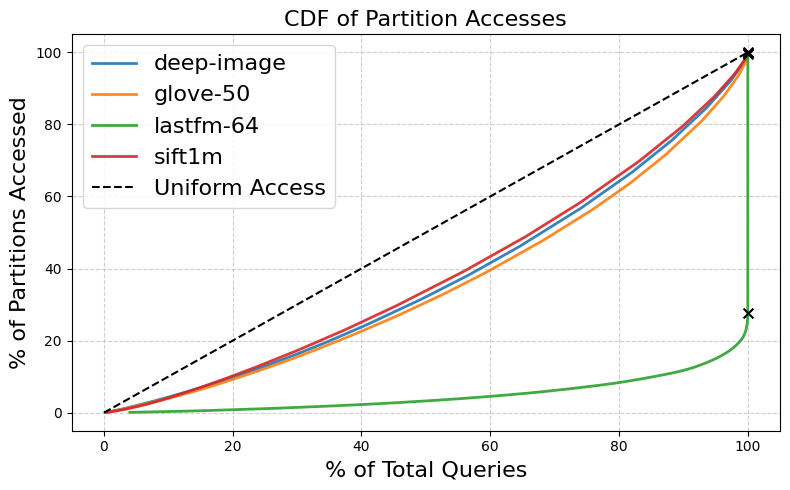

In [27]:
plot_cdf_flipped(combined_counts, search_nprobe, nqueries_dict, save_plot=True, normalize=False)#, yscale="linear")

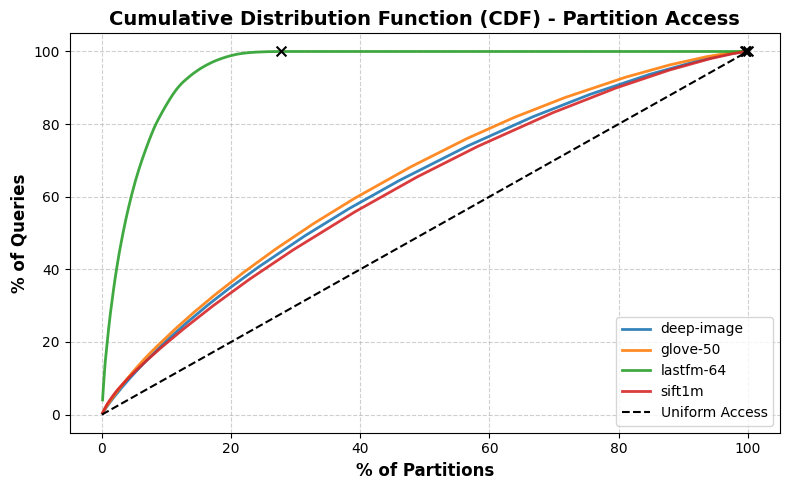

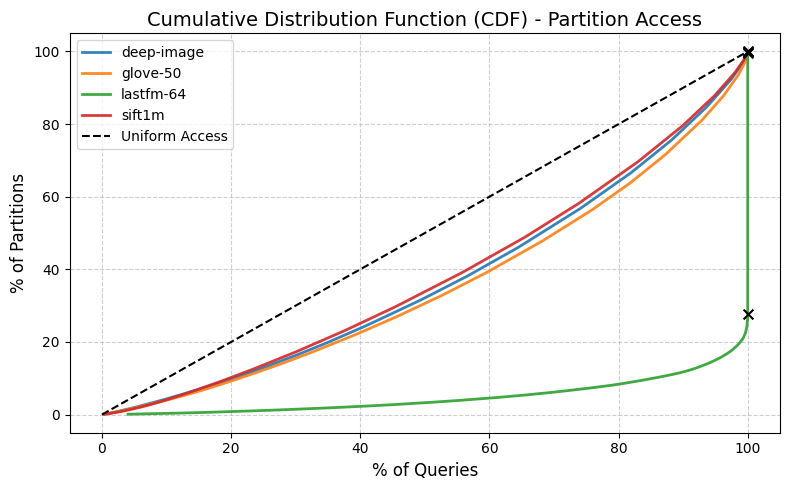

In [15]:
plot_cdf_combined(combined_counts, search_nprobe, nqueries_dict, save_plot=True, normalize=False)#, yscale="log")
plot_cdf_flipped(combined_counts, search_nprobe, nqueries_dict, save_plot=True, normalize=False)#, yscale="linear")

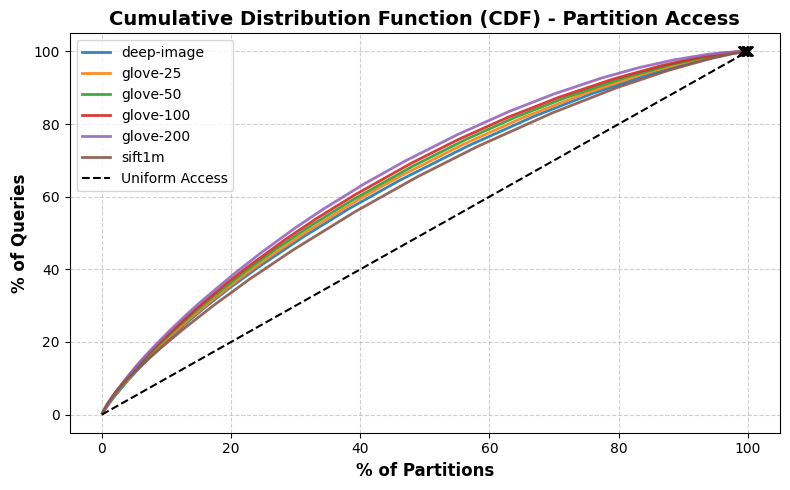

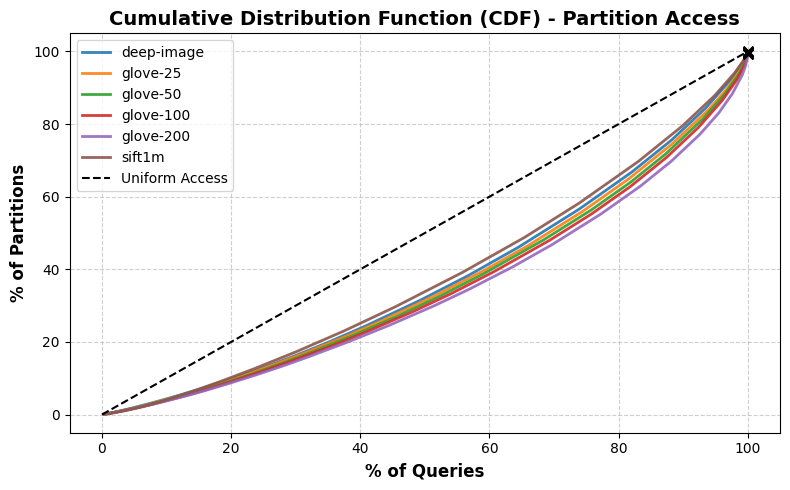

In [11]:
plot_cdf_combined(combined_counts, search_nprobe, nqueries_dict, save_plot=True, normalize=False)#, yscale="log")
plot_cdf_flipped(combined_counts, search_nprobe, nqueries_dict, save_plot=True, normalize=False)#, yscale="linear")